In [31]:
import pandas as pd
import numpy as np
import scanpy as sc
import scanpy.external as sce
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
import math
import warnings
import scvelo as scv
import cellrank as cr
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 0  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=500, frameon=False, vector_friendly=True, fontsize=14, figsize=None, color_map=None, format='pdf', facecolor=None, transparent=True)

In [32]:
import helper_functions_dew as dew
import pickle

### Import

In [33]:
X_data = sc.read_csv('mouse9_5/X.csv')

In [34]:
cell_data = pd.read_csv('mouse9_5/mmE95_CellData.csv', sep=",")

In [35]:
gene_data = pd.read_csv('mouse9_5/mmE95_GeneData.csv', sep=",")

In [36]:
gene_data.index = gene_data.gene_name

In [37]:
X_data.obs=cell_data

In [38]:
X_data.var=gene_data

In [39]:
X_data.obs['leiden_old'] = X_data.obs['leiden']

In [40]:
X_data.obs['leiden_old'] = X_data.obs['leiden_old'].replace(['aPSM'],'PSM Ant')
X_data.obs['leiden_old'] = X_data.obs['leiden_old'].replace(['pPSM'],'PSM Post')
X_data.obs['leiden_old'] = X_data.obs['leiden_old'].replace(['SOM'],'Somite')
X_data.obs['leiden_old'] = X_data.obs['leiden_old'].replace(['aNTB1'],'Neural')
X_data.obs['leiden_old'] = X_data.obs['leiden_old'].replace(['aNTB2'],'Neural')
X_data.obs['leiden_old'] = X_data.obs['leiden_old'].replace(['pNTB'],'Neural')

In [41]:
X_data = X_data[X_data.obs['leiden_old'].isin(['PSM Ant', 'PSM Post', 'Somite', 'Neural', 'NMP']),:]

### Process

In [42]:
sc.pp.normalize_total(X_data)

C:\ProgramData\Anaconda3\envs\jupyterlab\lib\site-packages\scanpy\preprocessing\_normalization.py:155: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)
C:\Users\Yannis\AppData\Roaming\Python\Python39\site-packages\anndata\_core\anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [43]:
sc.pp.log1p(X_data)

In [44]:
sc.pp.highly_variable_genes(X_data)

In [45]:
sc.pp.scale(X_data)

In [46]:
sc.tl.pca(X_data, n_comps=50)

In [47]:
sce.pp.bbknn(X_data, batch_key='batch')

In [48]:
sc.tl.umap(X_data)

... storing 'leiden' as categorical
... storing 'louvain' as categorical
... storing 'leiden_old' as categorical
... storing 'gene_name' as categorical


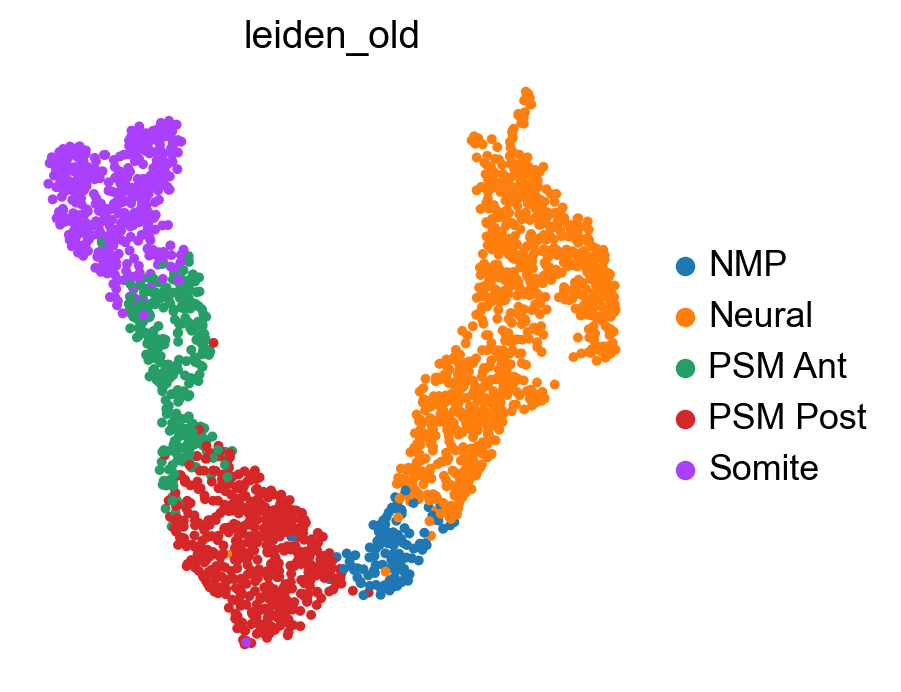

In [49]:
sc.pl.umap(X_data, color=['leiden_old'])

In [50]:
sc.tl.leiden(X_data, resolution=.4, key_added='leiden')

In [51]:
X_data.obs['leiden'] = X_data.obs['leiden'].replace(['0'],'PSM Post')
X_data.obs['leiden'] = X_data.obs['leiden'].replace(['1'],'Neural')
X_data.obs['leiden'] = X_data.obs['leiden'].replace(['2'],'NMP')
X_data.obs['leiden'] = X_data.obs['leiden'].replace(['3'],'Somite')
X_data.obs['leiden'] = X_data.obs['leiden'].replace(['4'],'PSM Ant')

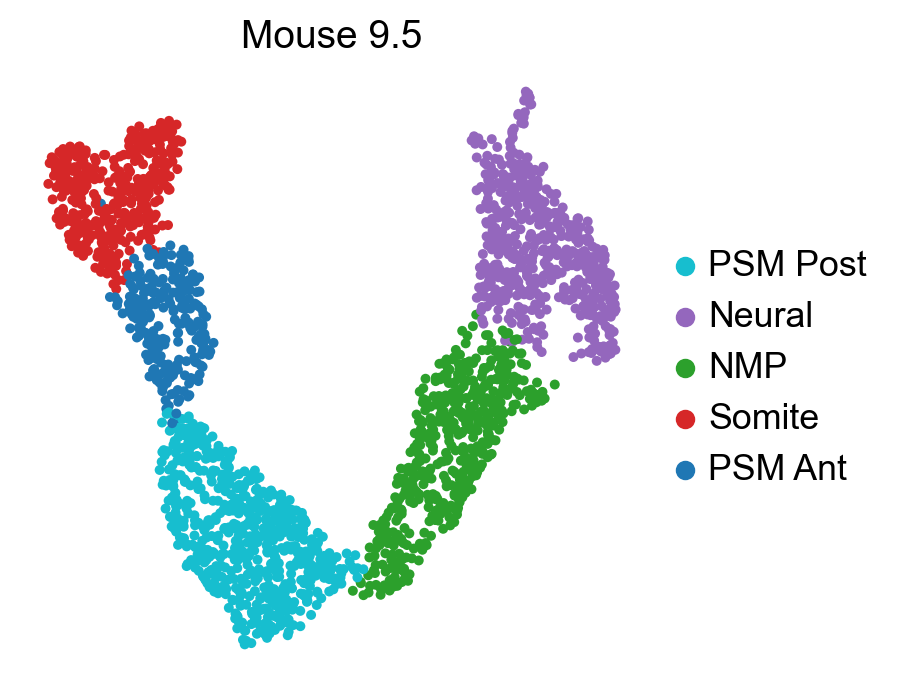

In [52]:
sc.pl.umap(X_data, color=['leiden'], save='mouse_e95.pdf', title='Mouse 9.5', palette=['tab:cyan', 'tab:purple', 'tab:green', 'tab:red', 'tab:blue'])

In [53]:
del X_data.obs['index']
X_data.obs_names = X_data.obs['unique_cell_id']
del X_data.obs['unique_cell_id']
X_data.var.index.name = None

In [54]:
X_data.write('data/mouse_9_5_diazcuadros.h5ad')

### Classifier

In [78]:
segmentoid = sc.read('data/somitoid_processed.h5ad')

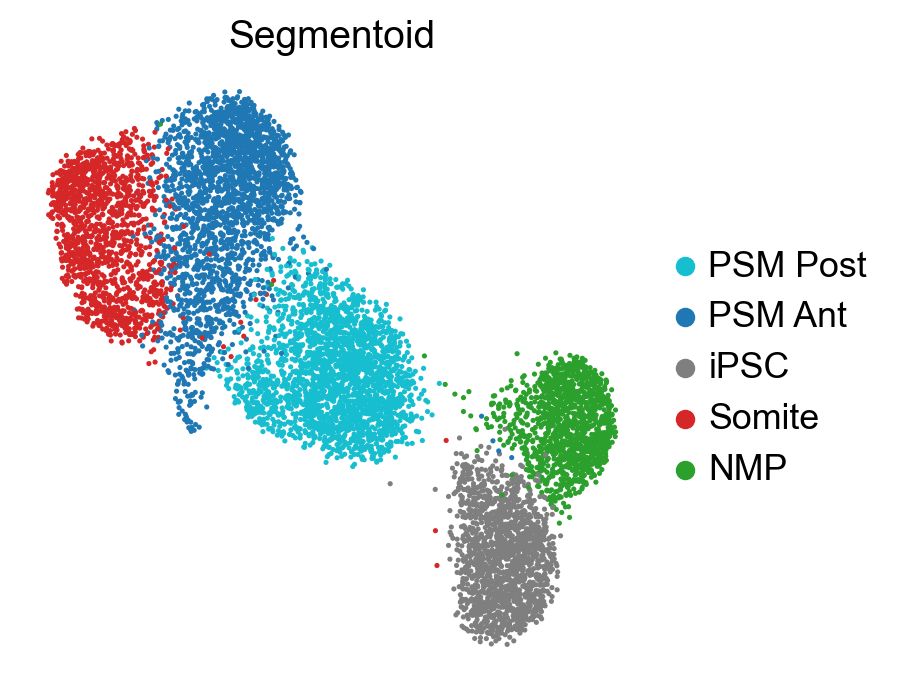

In [79]:
sc.pl.umap(segmentoid, color=['leiden'], save='somitoid.pdf', title='Segmentoid')

In [80]:
markers = ['HAS1', 'HAS2', 'HAS3', 'CD44', 'HMMR', 'HYAL1', 'HYAL2', 'HYAL3', 'HYAL4', 'HAPLN1', 'HAPLN2', 'HAPLN3', 'HAPLN4', 'CEMIP2']

In [81]:
order_dotplot = ['iPSC', 'NMP', 'PSM Post', 'PSM Ant', 'Somite']

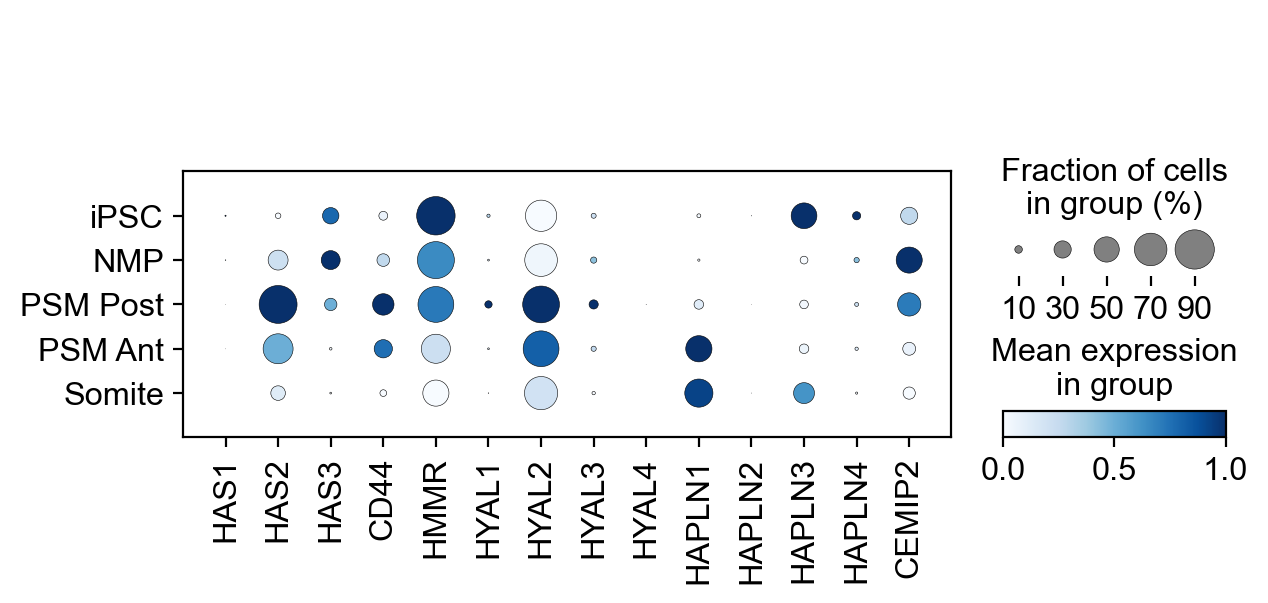

In [82]:
sc.pl.dotplot(segmentoid, markers, 'leiden', categories_order=order_dotplot, return_fig=False,color_map='Blues', standard_scale='var', save='dotplot_somitoid.pdf')

In [61]:
segmentoid = segmentoid[~segmentoid.obs['leiden'].isin(['iPSC']),:]

In [62]:
mouse_9_5Classifier = pickle.load(open('data/mouse_9_5Classifier.pickle','rb'))
segmentoid = dew.predict_classes(segmentoid, mouse_9_5Classifier)

Trying to set attribute `.X` of view, copying.


In [69]:
def plot_confusion_matrix_leiden(labels_A, labels_B,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues,
                          overlay_values=False,
                          vmin=None,
                          vmax=None,
                          return_data=False):
    '''
    Plots a confusion matrix comparing two sets labels. 

    '''

    from sklearn.metrics import confusion_matrix
    from sklearn.utils.multiclass import unique_labels
    
    cm = confusion_matrix(labels_A, labels_B,labels=['Neural','NMP', 'PSM Post', 'PSM Ant', 'Somite'])
    non_empty_rows = cm.sum(axis=0)!=0
    non_empty_cols = cm.sum(axis=1)!=0
    cm = cm[:,non_empty_rows]
    cm = cm[non_empty_cols,:]
    cm = cm.T
    
    classes = np.unique(labels_A.append(labels_B))
    xaxis_labels = classes[non_empty_cols]
    yaxis_labels = classes[non_empty_rows]

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    if normalize:
        colorbar_label = 'Fraction Overlap'
        if not title:
            title = 'Normalized confusion matrix'
    else:
        colorbar_label = '# Overlaps'
        if not title:
        	title = 'Confusion matrix, without normalization'  
  
    if hasattr(labels_A, 'name'):
        labels_A_name = labels_A.name #.capitalize()   	
    else:
        labels_A_name = 'Label A'
    if hasattr(labels_B, 'name'):
        labels_B_name = labels_B.name #.capitalize()    	
    else:
        labels_B_name = 'Label B'

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap, vmin=vmin, vmax=vmax)
    
    xaxis_labels=['Neural', 'NMP', 'PSM Post', 'PSM Ant', 'Somite']
    yaxis_labels=['NMP', 'PSM Post', 'PSM Ant', 'Somite']
    
    ax.grid(False)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=xaxis_labels, yticklabels=yaxis_labels,
           title=title,
           ylabel=labels_B_name,
           xlabel=labels_A_name)

    plt.setp(ax.get_xticklabels(), rotation=90, ha="right", va='top',
             rotation_mode='anchor',fontsize=10)
    plt.setp(ax.get_yticklabels(), fontsize=10)

    cb=ax.figure.colorbar(im, ax=ax, shrink=0.5)
    cb.ax.tick_params(labelsize=10) 
    cb.ax.set_ylabel(colorbar_label, rotation=90)
    
    if overlay_values:
        fmt = '.1f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black",
                        size=8)
    ax.set_aspect('equal') 
    
    if return_data:
        return fig, ax, cm, xaxis_labels, yaxis_labels                        
    else:
        return fig, ax                   


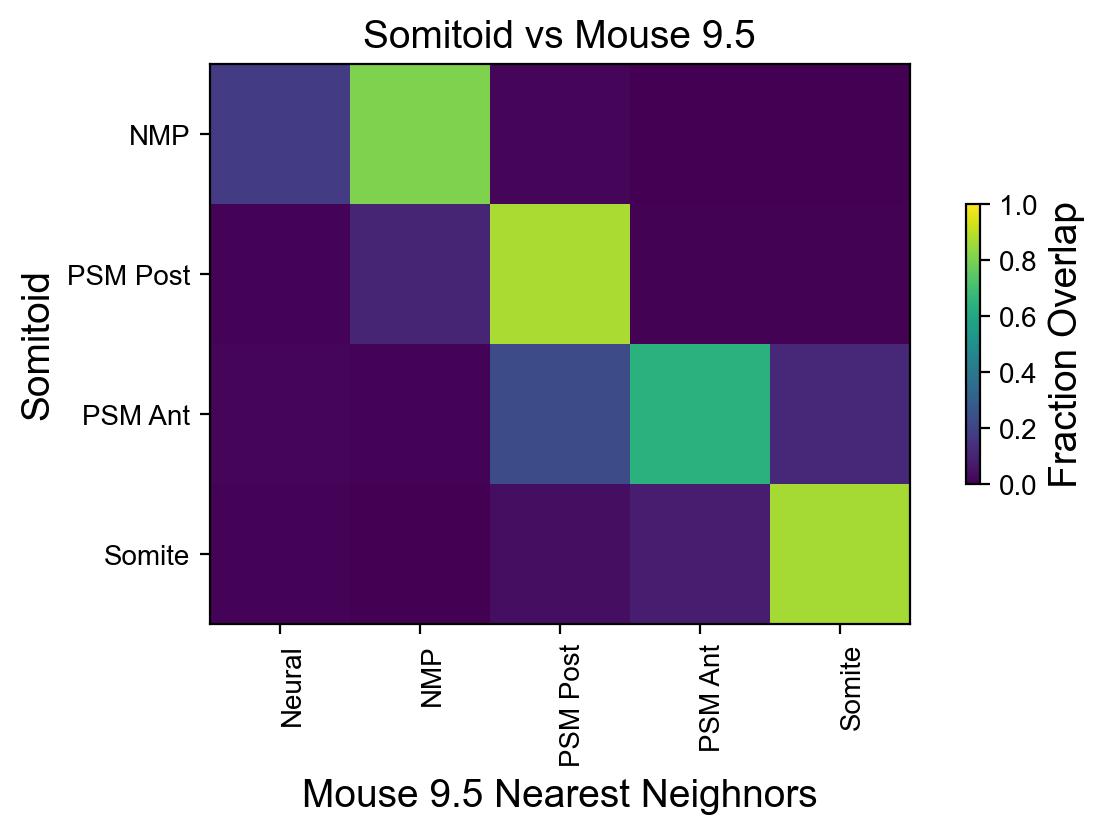

In [71]:
alg = ['NearestNeighbors']

for al in alg:
    plot_confusion_matrix_leiden(segmentoid.obs['pr_'+al],segmentoid.obs['leiden'], title=' ', 
                              normalize=True, cmap='viridis', vmin=0, vmax=1)
    plt.title("Somitoid vs Mouse 9.5")
    plt.ylabel("Somitoid")
    plt.xlabel("Mouse 9.5 Nearest Neighnors")
    plt.subplots_adjust(bottom=0, left=0, right=1.4, top=0.7)
    plt.savefig('figures/Mouse_vs_Somitoid_classifier.pdf', dpi=600, bbox_inches='tight')